In [89]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from functools import partial
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import warnings
warnings.filterwarnings("ignore")

In [90]:
def download_and_read_file(file, data_dir):
    local_filename = os.path.join(data_dir, file['title'])

    if not os.path.exists(local_filename):
        print(f"Downloading: {file['title']}")
        file.GetContentFile(local_filename)
    else:
        print(f"File already exists: {file['title']}")

    try:
        return pd.read_csv(local_filename)
    except Exception as e:
        print(f"Error while reading file {file['title']}: {e}")
        return None

def main():
    # 1. Auth
    gauth = GoogleAuth()
    gauth.LocalWebserverAuth()
    drive = GoogleDrive(gauth)

    # 2. ID of main folder
    main_folder_id = '1JuosK4Zv5-69AQmq-9mkJvQM7vR-h8wO'

    # 3. Create directory for local file storage
    data_dir = 'data'
    os.makedirs(data_dir, exist_ok=True)

    # 4. Find CSV in all folders
    csv_files = []
    main_folder = drive.ListFile({'q': f"'{main_folder_id}' in parents and trashed=false"}).GetList()

    for subfolder in main_folder:
        if subfolder['mimeType'] == 'application/vnd.google-apps.folder':
            subfolder_id = subfolder['id']
            files = drive.ListFile({'q': f"'{subfolder_id}' in parents and trashed=false"}).GetList()
            csv_files.extend([file for file in files if file['title'].lower().endswith('.csv')])

    # 5. Download and read CSV
    if not csv_files:
        print("No CSV files found.")
        return

    print(f"Found {len(csv_files)} CSV files to process.")

    with ThreadPoolExecutor(max_workers=32) as executor:
        dfs = list(executor.map(partial(download_and_read_file, data_dir=data_dir), csv_files))

    # 6. Combine data
    valid_dfs = [df for df in dfs if df is not None]

    if valid_dfs:
        combined_df = pd.concat(valid_dfs, ignore_index=True)
        print(f"Files combined. Total {len(combined_df)} rows.")
        return combined_df
    else:
        print("Unable to find any valid CSV files.")
        return None

if __name__ == "__main__":
    combined_df = main()

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=241406691172-h5fe30boo45ue428dh23nh8r8salfh2i.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.
Found 727 CSV files to process.
File already exists: Historia_przejazdow_2024-9-29_13_6_14.csv
File already exists: Historia_przejazdow_2024-9-4_12_44_18.csv
File already exists: Historia_przejazdow_2024-9-27_13_4_13.csv
File already exists: Historia_przejazdow_2024-9-30_13_7_13.csv
File already exists: Historia_przejazdow_2024-9-3_12_40_14.csv
File already exists: Historia_przejazdow_2024-9-8_12_45_13.csv
File already exists: Historia_przejazdow_2024-9-23_13_0_14.csv
File already exists: Historia_przejazdow_2024-9-2_12_39_15.csv
File already exists: Historia_przejazdow_2024-9-7_12_44_12.csv
File already exists: Historia_przejazdow_2024-9-24_13_1_14.csv
Fi

In [91]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3471263 entries, 0 to 3471262
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   UID wynajmu     object
 1   Numer roweru    object
 2   Data wynajmu    object
 3   Data zwrotu     object
 4   Stacja wynajmu  object
 5   Stacja zwrotu   object
 6   Czas trwania    object
dtypes: object(7)
memory usage: 185.4+ MB


In [92]:
combined_df[combined_df.duplicated()]

,UID wynajmu,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu,Czas trwania
1642931,200550431,602148,2023-09-18 06:16:55,2023-09-18 08:02:56,Aleja Kromera,Aleja Kromera,107
1646430,200621721,602387,2023-09-18 15:00:48,2023-09-18 16:19:45,Kozanowska / Pilczycka,Kozanowska / Pilczycka,79
1647982,200645962,602862,2023-09-18 16:49:50,2023-09-18 18:12:45,Wysoka Nastrojowa,Wysoka Nastrojowa,83
1648620,200655696,603371,2023-09-18 17:26:04,2023-09-18 18:56:29,Kościuszki / Pułaskiego,Na Grobli (PWr - Geocentrum),91
1648786,200658584,603424,2023-09-18 17:36:40,2023-09-18 19:11:15,Kozanowska/Pałucka,Lotnicza / Na Ostatnim Groszu,95
...,...,...,...,...,...,...,...
3445261,200884615,604172,2023-09-19 23:44:11,2023-09-19 23:55:34,Reymonta / Kleczkowska,Piłsudskiego 13 od Jump Hall,12
3445262,200884831,602536,2023-09-19 23:48:50,2023-09-19 23:55:55,Jagiełły / Dmowskiego,Gnieźnieńska / Długa,8
3445263,200885043,602842,2023-09-19 23:53:07,2023-09-19 23:58:32,Plac Legionów,Jagiełły / Dmowskiego,6
3445264,200885278,602695,2023-09-19 23:57:55,2023-09-19 23:58:34,Kazimierza Wielkiego (Helios),Kazimierza Wielkiego (Helios),1


## Drop duplicated entries


In [93]:
combined_df.drop_duplicates(inplace = True)

## Change data types

In [94]:
combined_df['UID wynajmu'] = combined_df['UID wynajmu'].astype(int)
combined_df['Numer roweru'] = combined_df['Numer roweru'].astype(int)
combined_df['Data wynajmu'] = pd.to_datetime(combined_df['Data wynajmu'])
combined_df['Data zwrotu'] = pd.to_datetime(combined_df['Data zwrotu'])
combined_df['Czas trwania'] = combined_df['Czas trwania'].astype(int)

In [95]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3242047 entries, 0 to 3471262
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   UID wynajmu     int32         
 1   Numer roweru    int32         
 2   Data wynajmu    datetime64[ns]
 3   Data zwrotu     datetime64[ns]
 4   Stacja wynajmu  object        
 5   Stacja zwrotu   object        
 6   Czas trwania    int32         
dtypes: datetime64[ns](2), int32(3), object(2)
memory usage: 160.8+ MB


In [96]:
combined_df.describe()

,UID wynajmu,Numer roweru,Data wynajmu,Data zwrotu,Czas trwania
count,3242047.000,3242047.000,3242047,3242047,3242047.000
mean,211667578.899,603961.888,2023-12-23 21:16:05.479789312,2023-12-23 21:51:05.044075776,35.225
min,168469379.000,29996.000,2022-12-30 07:46:54,2022-12-30 07:47:41,0.000
25%,187202847.000,602627.000,2023-06-26 16:01:15.500000,2023-06-26 16:21:34,6.000
50%,208831444.000,603245.000,2023-11-15 07:26:49,2023-11-15 08:18:56,11.000
75%,235069075.500,603865.000,2024-06-19 17:09:35,2024-06-19 17:29:07.500000,17.000
max,262329067.000,809013.000,2024-11-30 23:59:35,2024-12-04 09:19:40,731850.000
std,26612433.761,6996.904,NaN,NaN,2270.304


## Clean data by removing outliers

In [97]:
Q1 = combined_df['Czas trwania'].quantile(0.25)
Q3 = combined_df['Czas trwania'].quantile(0.75)
IQR = Q3 - Q1

# Keep values that are not outliers
mask = (combined_df['Czas trwania'] >= Q1 - 1.5 * IQR) & (combined_df['Czas trwania'] <= Q3 + 1.5 * IQR)

clean_df = combined_df[mask]

In [98]:
clean_df.describe()

,UID wynajmu,Numer roweru,Data wynajmu,Data zwrotu,Czas trwania
count,2986352.000,2986352.000,2986352,2986352,2986352.000
mean,211811955.675,603966.721,2023-12-24 19:01:34.046339072,2023-12-24 19:12:08.736824320,10.809
min,168469379.000,29996.000,2022-12-30 07:46:54,2022-12-30 07:47:41,0.000
25%,187388277.500,602626.000,2023-06-27 16:31:04,2023-06-27 16:42:31,6.000
50%,209030066.000,603245.000,2023-11-16 15:43:32,2023-11-16 15:52:13,10.000
75%,235259601.250,603865.000,2024-06-20 16:02:11,2024-06-20 16:11:43.500000,15.000
max,262329067.000,809013.000,2024-11-30 23:59:35,2024-12-01 00:08:02,33.000
std,26641121.732,6953.834,NaN,NaN,6.817


In [99]:
## Leave data only for 2023 and 2024
clean_df = clean_df.loc[clean_df['Data wynajmu'] >='2023-01-01']

In [100]:
print (f"After cleaning, {round((len(clean_df)/len(combined_df)),2) * 100}% of data remains.")

After cleaning, 92.0% of data remains.


## Importing libraries for vis and datetime calculations

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

## Distribution of ride durations

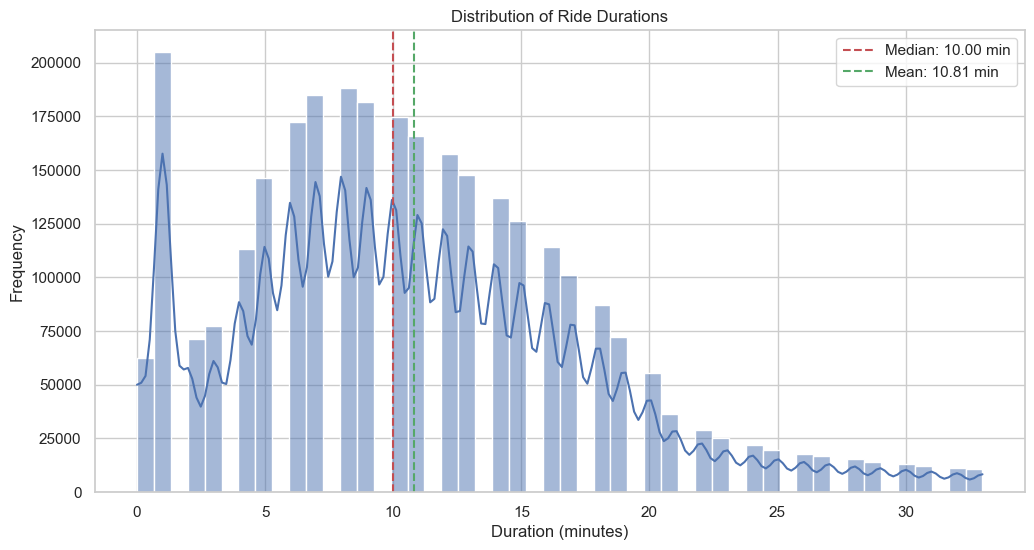

In [102]:
plt.figure(figsize=(12, 6))
sns.histplot(clean_df['Czas trwania'], bins=50, kde=True)
plt.title('Distribution of Ride Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.axvline(x=clean_df['Czas trwania'].median(), color='r', linestyle='--', label=f"Median: {clean_df['Czas trwania'].median():.2f} min")
plt.axvline(x=clean_df['Czas trwania'].mean(), color='g', linestyle='--', label=f"Mean: {clean_df['Czas trwania'].mean():.2f} min")
plt.legend()
plt.show()

# Very short rides

In [103]:
short_rides = clean_df[clean_df['Czas trwania'] <= 1]
print(f"\nVery short rides (<1 minute): {len(short_rides)}")
print(f"Percentage of very short rides: {len(short_rides) / len(clean_df) * 100:.2f}%")


Very short rides (<1 minute): 267482
Percentage of very short rides: 8.96%


## Duration by time of day

In [104]:
clean_df['Hour_of_Day'] = clean_df['Data wynajmu'].dt.hour

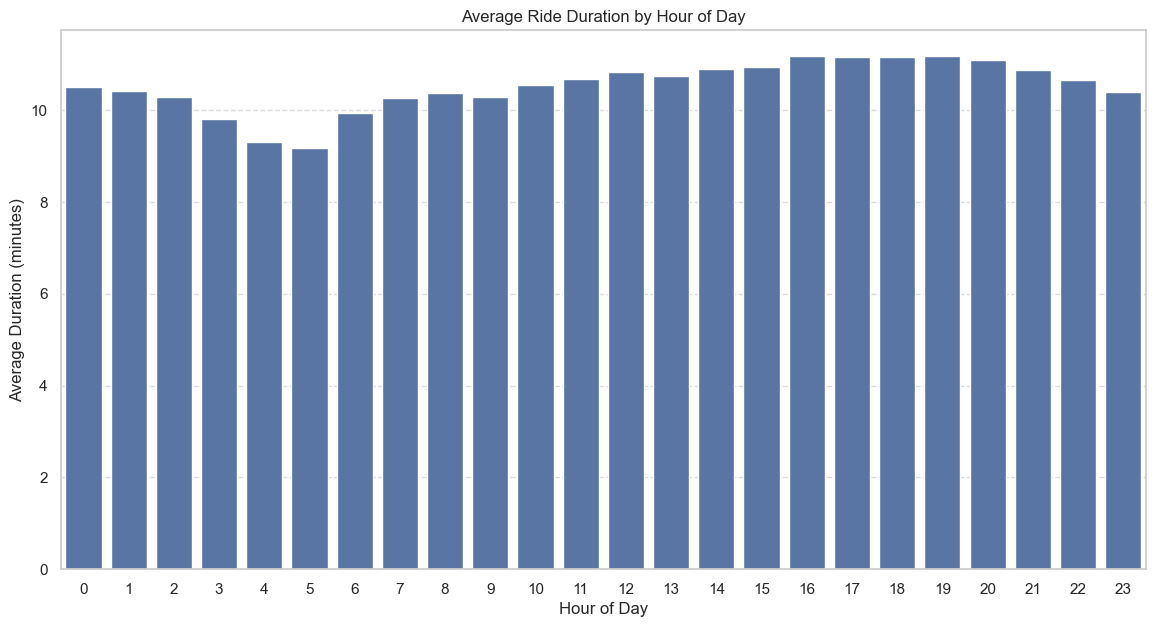

In [105]:
plt.figure(figsize=(14, 7))
average_duration_by_hour = clean_df.groupby('Hour_of_Day')['Czas trwania'].mean()
sns.barplot(x=average_duration_by_hour.index, y=average_duration_by_hour.values)
plt.title('Average Ride Duration by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Duration (minutes)')
plt.xticks(np.arange(0, 24, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Duration by day of week

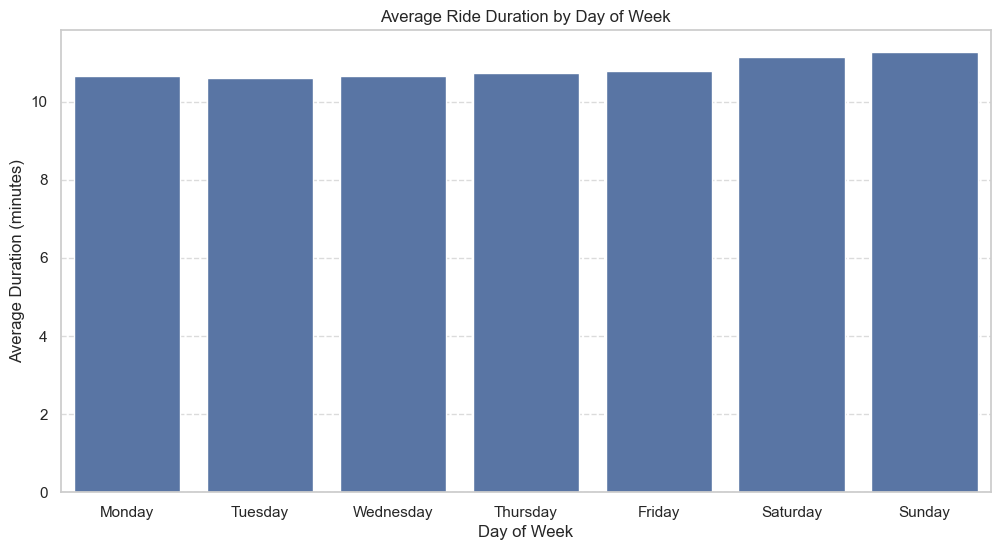

In [106]:
clean_df['Day_of_Week'] = clean_df['Data wynajmu'].dt.dayofweek
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
average_duration_by_day = clean_df.groupby('Day_of_Week')['Czas trwania'].mean()
sns.barplot(x=average_duration_by_day.index, y=average_duration_by_day.values)
plt.title('Average Ride Duration by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Duration (minutes)')
plt.xticks(np.arange(0, 7, 1), day_names)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Check if weekday vs weekend rides have different durations

In [107]:
clean_df['Is_Weekend'] = clean_df['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)
weekday_avg = clean_df[clean_df['Is_Weekend'] == 0]['Czas trwania'].mean()
weekend_avg = clean_df[clean_df['Is_Weekend'] == 1]['Czas trwania'].mean()

print(f"\nAverage weekday ride duration: {weekday_avg:.2f} minutes")
print(f"Average weekend ride duration: {weekend_avg:.2f} minutes")
print(f"Weekend rides are {(weekend_avg/weekday_avg - 1)*100:.2f}% longer than weekday rides")


Average weekday ride duration: 10.68 minutes
Average weekend ride duration: 11.19 minutes
Weekend rides are 4.75% longer than weekday rides


## Seasonal patterns in ride duration if data spans multiple months

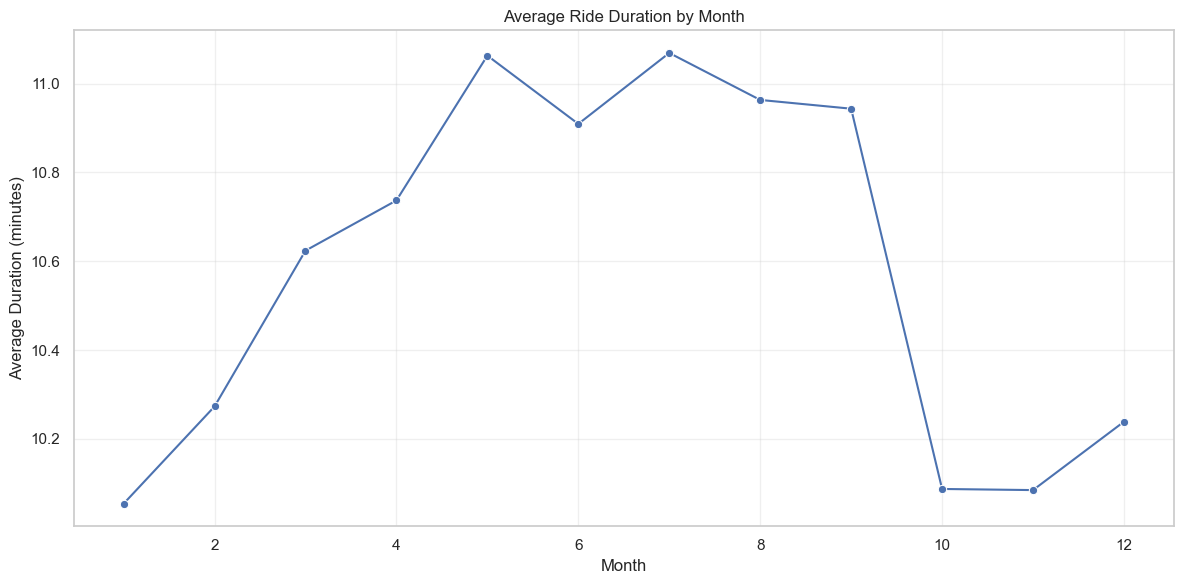

In [108]:
if 'month' not in clean_df.columns and len(clean_df['Data wynajmu'].dt.month.unique()) > 1:
    clean_df['Month'] = clean_df['Data wynajmu'].dt.month

    plt.figure(figsize=(12, 6))
    monthly_duration = clean_df.groupby('Month')['Czas trwania'].mean()
    sns.lineplot(x=monthly_duration.index, y=monthly_duration.values, marker='o')
    plt.title('Average Ride Duration by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Duration (minutes)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Duration by popular station pairs

In [109]:
top_routes = clean_df.groupby(['Stacja wynajmu', 'Stacja zwrotu']).size().sort_values(ascending=False).head(10)
route_durations = clean_df.groupby(['Stacja wynajmu', 'Stacja zwrotu'])['Czas trwania'].mean()

print("\nTop 10 routes and their average durations:")
for (start, end), count in top_routes.items():
    avg_duration = route_durations[(start, end)]
    print(f"{start} → {end}: {count} rides, {avg_duration:.2f} minutes average")


Top 10 routes and their average durations:
Poza stacją → Poza stacją: 36378 rides, 9.29 minutes average
Dworzec Główny  → Dworzec Główny : 6988 rides, 2.33 minutes average
Dworzec Główny, południe → Dworzec Główny, południe: 6501 rides, 2.46 minutes average
Rynek → Rynek: 6457 rides, 3.02 minutes average
Szczęśliwa (Sky Tower) → Szczęśliwa (Sky Tower): 6285 rides, 2.63 minutes average
Plac Dominikański (Galeria Dominikańska) → Plac Dominikański (Galeria Dominikańska): 6270 rides, 3.02 minutes average
Kościuszki / Pułaskiego → Kościuszki / Pułaskiego: 6010 rides, 2.73 minutes average
Piaskowa / św. Ducha → Piaskowa / św. Ducha: 5176 rides, 2.47 minutes average
Legnicka (Park Magnolia) → Legnicka (Park Magnolia): 5107 rides, 3.64 minutes average
al. Armii Krajowej / Borowska → al. Armii Krajowej / Borowska: 4953 rides, 2.53 minutes average


## Comparison of Bike Rentals between 2023 and 2024

In [110]:
clean_df['Year'] = clean_df['Data wynajmu'].dt.year

In [111]:
year_counts = clean_df['Year'].value_counts()
print("Number of rides per year:")
print(year_counts)

Number of rides per year:
Year
2023    1558260
2024    1428070
Name: count, dtype: int64


## Create subsets for each year

In [112]:
df_2023 = clean_df[clean_df['Year'] == 2023]
df_2024 = clean_df[clean_df['Year'] == 2024]

## Overall volume comparison

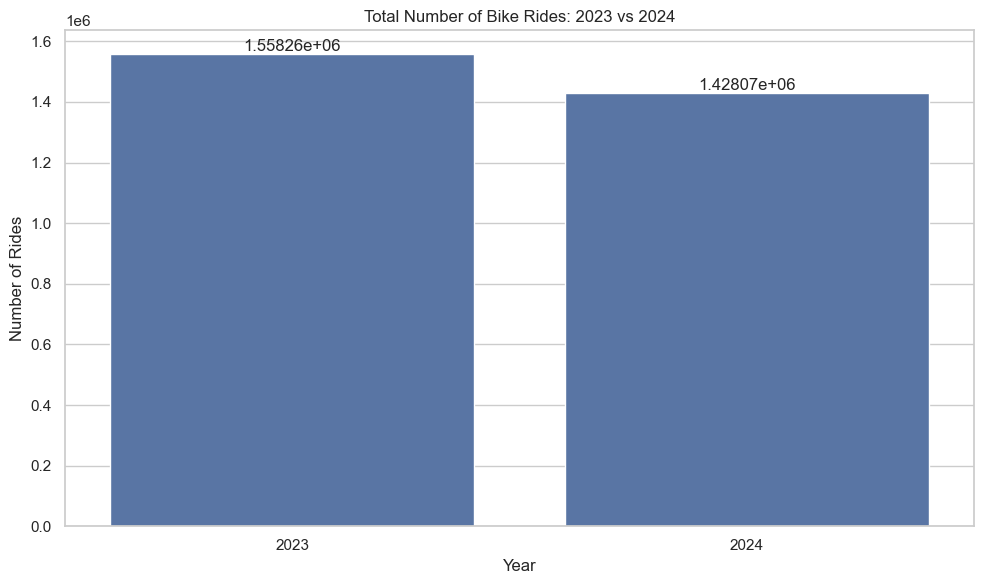

In [113]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='Year', data=clean_df)
plt.title('Total Number of Bike Rides: 2023 vs 2024')
plt.ylabel('Number of Rides')
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

## Calculate and print summary statistics

In [114]:
duration_stats_by_year = clean_df.groupby('Year')['Czas trwania'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nRide Duration Statistics (in minutes):")
print(duration_stats_by_year)


Ride Duration Statistics (in minutes):
       mean  median   std  min  max
Year                               
2023 11.087  10.000 6.777    0   33
2024 10.505  10.000 6.849    0   33


## Plotting monthly trends

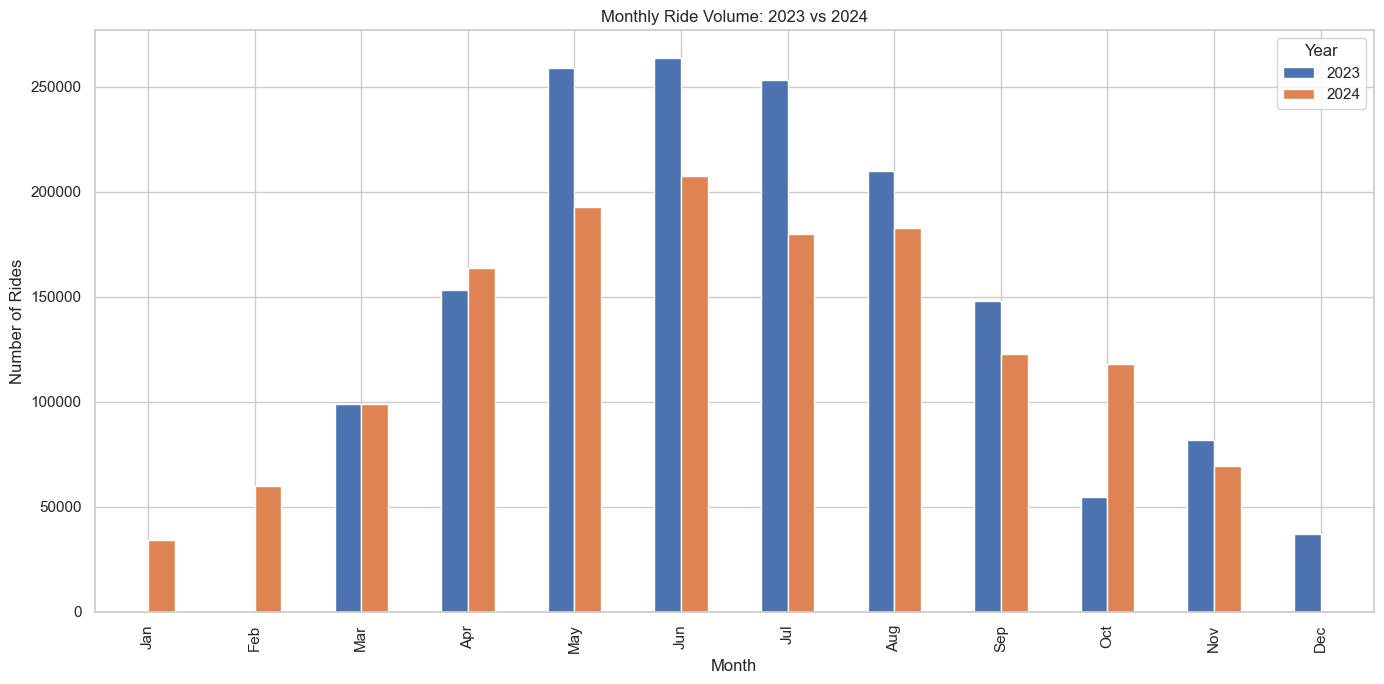

In [115]:
monthly_counts = clean_df.groupby(['Year', 'Month']).size().unstack(level=0)

# Plotting monthly trends
plt.figure(figsize=(14, 7))
monthly_counts.plot(kind='bar', ax=plt.gca())
plt.title('Monthly Ride Volume: 2023 vs 2024')
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.tight_layout()
plt.show()

## Time of day comparison (hourly patterns)

In [116]:
hourly_counts_by_year = clean_df.groupby(['Year', 'Hour_of_Day']).size().unstack(level=0)

<Figure size 3000x3000 with 0 Axes>

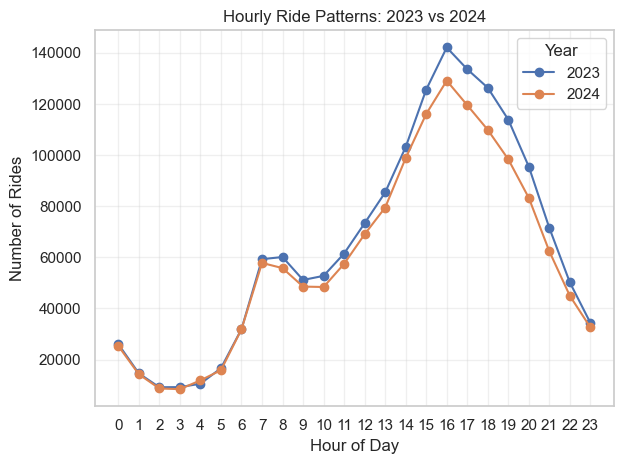

In [117]:
plt.figure(figsize=(30, 30))
hourly_counts_by_year.plot(kind='line', marker='o')
plt.title('Hourly Ride Patterns: 2023 vs 2024')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.xticks(range(24))
plt.grid(True, alpha=0.3)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

## Day of week comparison

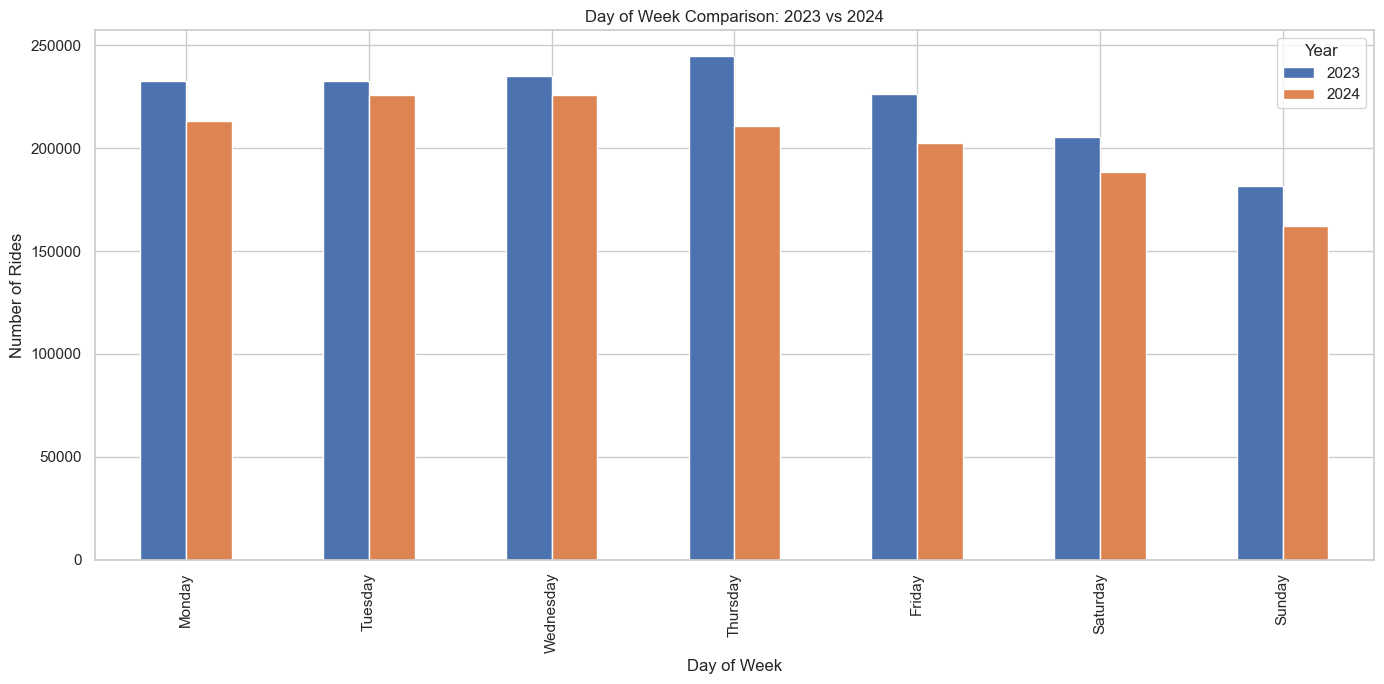

In [118]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

dow_counts_by_year = clean_df.groupby(['Year', 'Day_of_Week']).size().unstack(level=0)

plt.figure(figsize=(14, 7))
dow_counts_by_year.plot(kind='bar', ax=plt.gca())
plt.title('Day of Week Comparison: 2023 vs 2024')
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.xticks(range(7), days)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

## Top 10 rental stations for each year

In [119]:
top_stations_2023 = df_2023['Stacja wynajmu'].value_counts().head(10)
top_stations_2024 = df_2024['Stacja wynajmu'].value_counts().head(10)

In [120]:
print("\nTop 10 Rental Stations in 2023:")
print(top_stations_2023)
print("\nTop 10 Rental Stations in 2024:")
print(top_stations_2024)


Top 10 Rental Stations in 2023:
Stacja wynajmu
Poza stacją                                 84794
Dworzec Główny, południe                    29395
Dworzec Główny                              28249
Plac Dominikański (Galeria Dominikańska)    26054
Rondo Reagana                               21079
Legnicka (Park Magnolia)                    20774
Rynek                                       19869
Szczęśliwa (Sky Tower)                      19464
Dyrekcyjna / Borowska (Wroclavia)           18939
al. Armii Krajowej / Borowska               18630
Name: count, dtype: int64

Top 10 Rental Stations in 2024:
Stacja wynajmu
Poza stacją                                 86783
Dworzec Główny, południe                    27272
Dworzec Główny                              25410
Szczęśliwa (Sky Tower)                      22922
Plac Dominikański (Galeria Dominikańska)    22735
Legnicka (Park Magnolia)                    17150
Rondo Reagana                               16901
al. Armii Krajowej / Borowsk

## Find common stations in top 10

In [121]:
common_stations = set(top_stations_2023.index) & set(top_stations_2024.index)
print(f"\nNumber of stations that remained in top 10 both years: {len(common_stations)}")
print("These stations are:", common_stations)


Number of stations that remained in top 10 both years: 9
These stations are: {'Rynek', 'Dworzec Główny ', 'Szczęśliwa (Sky Tower)', 'Dworzec Główny, południe', 'Plac Dominikański (Galeria Dominikańska)', 'Rondo Reagana', 'al. Armii Krajowej / Borowska', 'Poza stacją', 'Legnicka (Park Magnolia)'}


## Route comparison

In [122]:
routes_2023 = df_2023.groupby(['Stacja wynajmu', 'Stacja zwrotu']).size().reset_index(name='count')
routes_2024 = df_2024.groupby(['Stacja wynajmu', 'Stacja zwrotu']).size().reset_index(name='count')

top_routes_2023 = routes_2023.sort_values('count', ascending=False).head(10)
top_routes_2024 = routes_2024.sort_values('count', ascending=False).head(10)

print("\nTop 10 Routes in 2023:")
print(top_routes_2023)
print("\nTop 10 Routes in 2024:")
print(top_routes_2024)


Top 10 Routes in 2023:
                                 Stacja wynajmu  \
17631                               Poza stacją   
2738                            Dworzec Główny    
2928                   Dworzec Główny, południe   
18984                                     Rynek   
14740  Plac Dominikański (Galeria Dominikańska)   
8637                    Kościuszki / Pułaskiego   
9786                   Legnicka (Park Magnolia)   
20374                    Szczęśliwa (Sky Tower)   
18805                             Rondo Reagana   
3108          Dyrekcyjna / Borowska (Wroclavia)   

                                  Stacja zwrotu  count  
17631                               Poza stacją  16102  
2738                            Dworzec Główny    3533  
2928                   Dworzec Główny, południe   3386  
18984                                     Rynek   3148  
14740  Plac Dominikański (Galeria Dominikańska)   3102  
8637                    Kościuszki / Pułaskiego   3074  
9786           

## Growth and pattern change summary

In [123]:
print("\n--- Summary of Changes from 2023 to 2024 ---")
total_change = (len(df_2024) / len(df_2023) - 1) * 100
print(f"Overall ride volume change: {total_change:.2f}%")


avg_duration_2023 = df_2023['Czas trwania'].mean() / 60
avg_duration_2024 = df_2024['Czas trwania'].mean() / 60
duration_change = (avg_duration_2024 / avg_duration_2023 - 1) * 100
print(f"Average ride duration change: {duration_change:.2f}% ({avg_duration_2023:.2f} min to {avg_duration_2024:.2f} min)")


months_2023 = set(df_2023['Month'].unique())
months_2024 = set(df_2024['Month'].unique())
common_months = months_2023 & months_2024

if len(common_months) > 0:
    # For fair comparison, only use months present in both years
    comparable_df = clean_df[clean_df['Month'].isin(common_months)]
    comparable_2023 = comparable_df[comparable_df['Year'] == 2023]
    comparable_2024 = comparable_df[comparable_df['Year'] == 2024]

    comparable_change = (len(comparable_2024) / len(comparable_2023) - 1) * 100
    print(f"\nFor months present in both years ({sorted(common_months)})")
    print(f"Comparable period ride volume change: {comparable_change:.2f}%")


--- Summary of Changes from 2023 to 2024 ---
Overall ride volume change: -8.35%
Average ride duration change: -5.25% (0.18 min to 0.18 min)

For months present in both years ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
Comparable period ride volume change: -6.14%
